In [1]:
import os
import glob
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"      
os.environ["KERAS_BACKEND"]        = "tensorflow" 
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")  
AUTOTUNE = tf.data.AUTOTUNE                         
from tensorflow.keras import layers, models, optimizers, callbacks, utils
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D,MaxPooling2D, Dropout, Dense, Cropping2D, CenterCrop)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, f1_score)

2025-05-12 08:57:15.779128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747058235.791752    2590 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747058235.795802    2590 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747058235.804957    2590 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747058235.804972    2590 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747058235.804974    2590 computation_placer.cc:177] computation placer alr

In [2]:
def hist_return(hist_in):
    return (hist_in.history['accuracy'][:],hist_in.history['val_accuracy'][:],hist_in.history['loss'][:],hist_in.history['val_loss'][:])

In [3]:
def plotter(hist_acc,hist_val_acc,hist_loss,hist_val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(hist_acc,    label='Train Acc')
    axs[0].plot(hist_val_acc, label='Valid. Acc')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].set_title('Training vs Validation Accuracy')
    axs[1].plot(hist_loss,    label='Train Loss')
    axs[1].plot(hist_val_loss, label='Valid. Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].set_title('Training vs. Validation Loss')
    fig.tight_layout()
    plt.show()

## Project Description
<hr>

The purpose of this project is to develop a deep learning network that can detect whether an X-ray image is positive for pneumonia or not. And then, I will attempt to develop a model that can determine whether an X-ray image is normal, pneumonia (bacterial), or pneumonia (viral). This is an interesting real world case because AI-driven models are probably going to be introduced into the medical field more and more for different tasks, including this one.

It's an important project because I can see many medical tasks being automated in the future and reviewing Xrays, CT Scans, MRIs, etc is one of the leading examples that AI will be used first. I wanted to see if I could generate something that would produce decent results. High accuracy or at least high-sensitivity results would be a bonus.

The first task will be to determine whether an X-ray is normal or if there is pneumonia in the lungs. This is a binary classification 0/1 problem where the labels are known during training. I will attempt this with a Convolutional Neural Network (CNN) and then a Resnet network.

The second task is to determine whether an X-ray is normal, bacterial pneumonia, or viral pneumonia. This is a categorical classification problem 0/1/2 where the labels are known during training. I will also attempt this with a CNN and then a Resnet Network.

*github link*: https://github.com/lsiver/ml3_final

## Data
<hr>

Below I'm importing the data. The data is a bunch of Xray images of various sizes. There is a training set which has normal and pneumonia positive xrays and a test set which has normal and pneumonia positive xrays. This data was taken from Kaggle and is originally sourced from the Guangzhou Women and Children's Medical Center. All Xrays were screened for quality control by radiologists by removing all low quality or unreadable scans before being added to this dataset. This is a dataset that is available publicly.

#### Data Size
**Train** - 1.07 GB, 1341 normal images + 3875 pneumonia images, ~1000 x 1000 pixels, single channel, .jpeg format

**Test** - 75.3 MB, 234 normal images + 390 pneumonia images, ~1000 x 1000 pixels, single channel, .jpeg format

#### *Reference*
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), *"Labeled Optical Coherence Tomography (OCT) and Chest X-ray Images for Classification"*, Mendelay Data, v2

In [222]:
train_normal_fnames = glob(os.path.join('/home/lukeunix/tf-env/Final - Xray/train/NORMAL','*.jpeg'))
train_pneu_fnames = glob(os.path.join('/home/lukeunix/tf-env/Final - Xray/train/PNEUMONIA','*.jpeg'))
test_normal_fnames = glob(os.path.join('/home/lukeunix/tf-env/Final - Xray/test/NORMAL','*.jpeg'))
test_pneu_fnames = glob(os.path.join('/home/lukeunix/tf-env/Final - Xray/test/PNEUMONIA','*.jpeg'))

## Exploratory Data Analysis
<hr>

A few normal and pneumonia positive X-rays are shown below. Pneumonia positive X-rays should show additional "moisture" in the lungs that should show up as patchy whiteness. This is probably difficult to notice unless you're a professional and you're looking at the full 1000 x 1000 pixel image. A neural network should easily detect these areas though since they will hopefully be "outliers" after the model is trained against normal X-rays and pneumonia containing X-rays. 

In general, the pneumonia containing Xrays do appear more opaque due to the white areas, but these may be serious cases that are shown. Often it can be a small white patch in its initial stages.

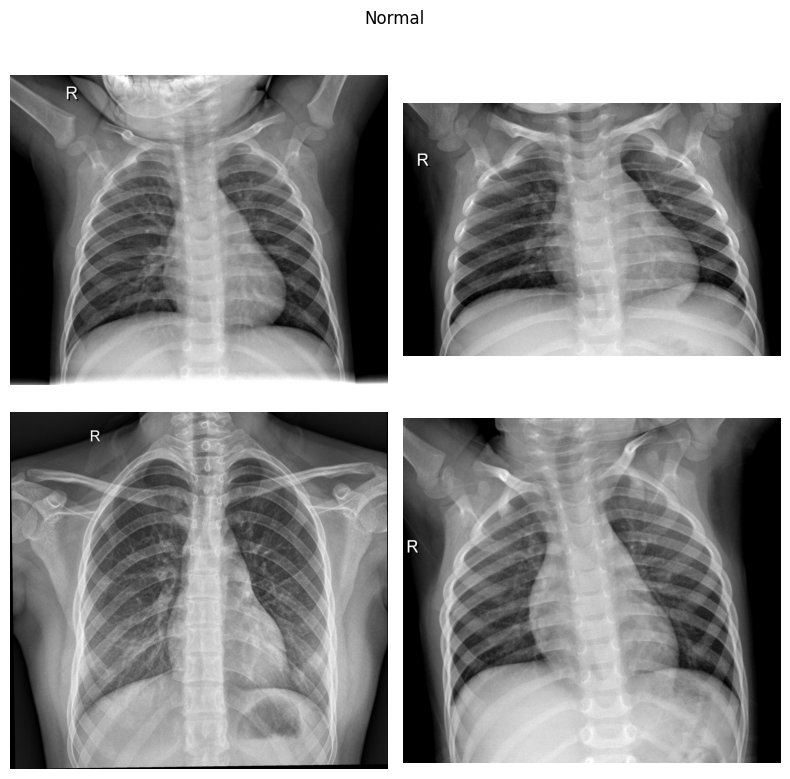

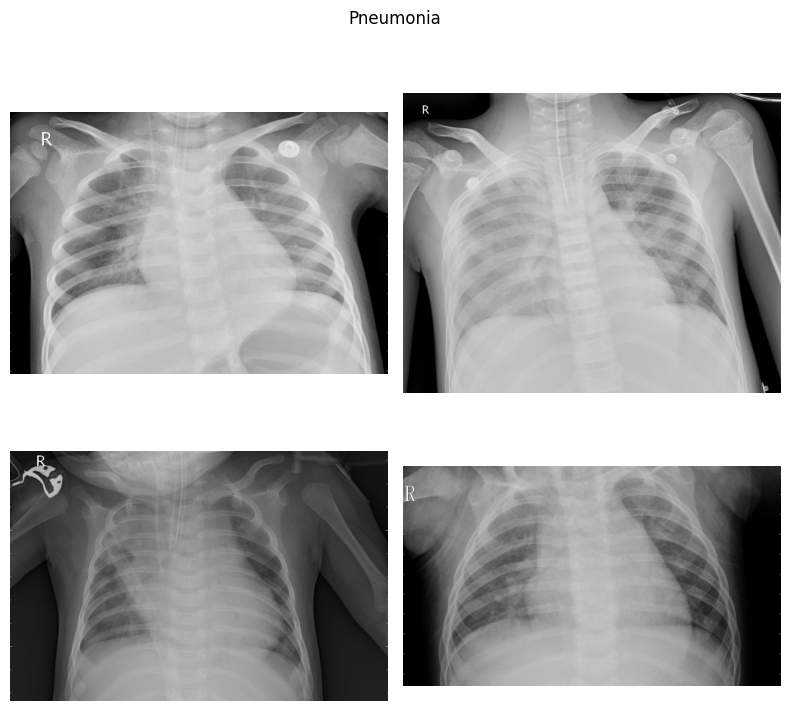

In [5]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
axes = axes.flatten()
for ax,img in zip(axes,train_normal_fnames):
    img = Image.open(img).convert('L')
    ax.imshow(img,cmap='gray')
    ax.axis('off')
plt.suptitle('Normal')
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2,2,figsize=(8,8))
axes = axes.flatten()
for ax,img in zip(axes,train_pneu_fnames):
    img = Image.open(img).convert('L')
    ax.imshow(img,cmap='gray')
    ax.axis('off')
plt.suptitle('Pneumonia')
plt.tight_layout()
plt.show()

The dataframe is created below. I have one column `label` that will be used for the simple model of detecting whether pneumonia is present or not (0/1), the binary case.

I have another column `type` which describes whether the lungs/Xray is normal, bacteria (pneumonia), or viral (pneumonia). This will be used for the model that will determine the type of pneumonia as well.

In [6]:
zeros_train_normal = list(np.zeros(len(train_normal_fnames)))
zeros_train_pneu = list(np.ones(len(train_pneu_fnames)))
train_total_names = train_normal_fnames + train_pneu_fnames
train_total_labels = zeros_train_normal + zeros_train_pneu
####
zeros_test_normal = list(np.zeros(len(test_normal_fnames)))
zeros_test_pneu = list(np.ones(len(test_pneu_fnames)))
test_total_names = test_normal_fnames + test_pneu_fnames
test_total_labels = zeros_test_normal + zeros_test_pneu

In [7]:
train_df = pd.DataFrame({'filename':train_total_names,'label':train_total_labels})
train_df['full'] = train_df['filename']
train_df['filename'] = train_df['filename'].apply(os.path.basename)
train_df['part_path'] = np.where(train_df['label'] ==0, '/home/lukeunix/tf-env/Final - Xray/train/NORMAL/','/home/lukeunix/tf-env/Final - Xray/train/PNEUNOMIA')
####
test_df = pd.DataFrame({'filename':test_total_names,'label':test_total_labels})
test_df['full'] = test_df['filename']
test_df['filename'] = test_df['filename'].apply(os.path.basename)
test_df['part_path'] = np.where(test_df['label'] ==0, '/home/lukeunix/tf-env/Final - Xray/test/NORMAL/','/home/lukeunix/tf-env/Final - Xray/test/PNEUNOMIA')

In [8]:
train_df['type'] = np.where(train_df['label'] == 0, 'normal','pneumonia')
mask_bact = train_df['filename'].str.contains('bacteria',case=False, na=False)
train_df.loc[mask_bact,'type'] = 'bacteria'
mask_vir = train_df['filename'].str.contains('virus',case=False, na=False)
train_df.loc[mask_vir,'type'] = 'virus'
#####
test_df['type'] = np.where(test_df['label'] == 0, 'normal','pneumonia')
mask_bact = test_df['filename'].str.contains('bacteria',case=False, na=False)
test_df.loc[mask_bact,'type'] = 'bacteria'
mask_vir = test_df['filename'].str.contains('virus',case=False, na=False)
test_df.loc[mask_vir,'type'] = 'virus'

In [9]:
train_df.head()

,filename,label,full,part_path,type
0,IM-0718-0001.jpeg,0.0,/home/lukeunix/tf-env/Final - Xray/train/NORMA...,/home/lukeunix/tf-env/Final - Xray/train/NORMAL/,normal
1,NORMAL2-IM-0517-0001.jpeg,0.0,/home/lukeunix/tf-env/Final - Xray/train/NORMA...,/home/lukeunix/tf-env/Final - Xray/train/NORMAL/,normal
2,NORMAL2-IM-0927-0001.jpeg,0.0,/home/lukeunix/tf-env/Final - Xray/train/NORMA...,/home/lukeunix/tf-env/Final - Xray/train/NORMAL/,normal
3,NORMAL2-IM-1321-0001.jpeg,0.0,/home/lukeunix/tf-env/Final - Xray/train/NORMA...,/home/lukeunix/tf-env/Final - Xray/train/NORMAL/,normal
4,NORMAL2-IM-1161-0001.jpeg,0.0,/home/lukeunix/tf-env/Final - Xray/train/NORMA...,/home/lukeunix/tf-env/Final - Xray/train/NORMAL/,normal


<hr>

The label counts for the training and test sets are shown below. The label skew could be an issue but this will be revisited if the accuracy of the test set is poor. The real problem with the data is the small amount of normal Xrays. The model may have a difficult time detecting true normal Xrays.

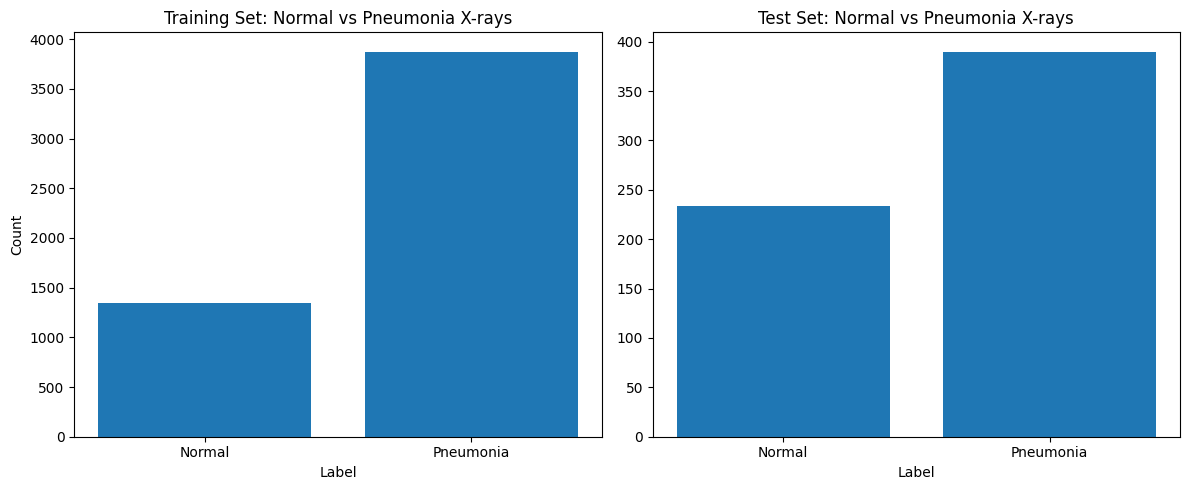

In [10]:
train_counts = train_df['label'].value_counts()
test_counts = test_df['label'].value_counts()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (12,5), sharey=False)

ax1.bar(train_counts.index, train_counts.values)
ax1.set_title('Training Set: Normal vs Pneumonia X-rays')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Normal', 'Pneumonia'])

ax2.bar(test_counts.index, test_counts.values)
ax2.set_title('Test Set: Normal vs Pneumonia X-rays')
ax2.set_xlabel('Label')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Normal', 'Pneumonia'])
plt.tight_layout()
plt.show()

<hr>

The below charts show the breakdown between the pneumonia types: viral or bacterial vs normal (no pneumonia present)

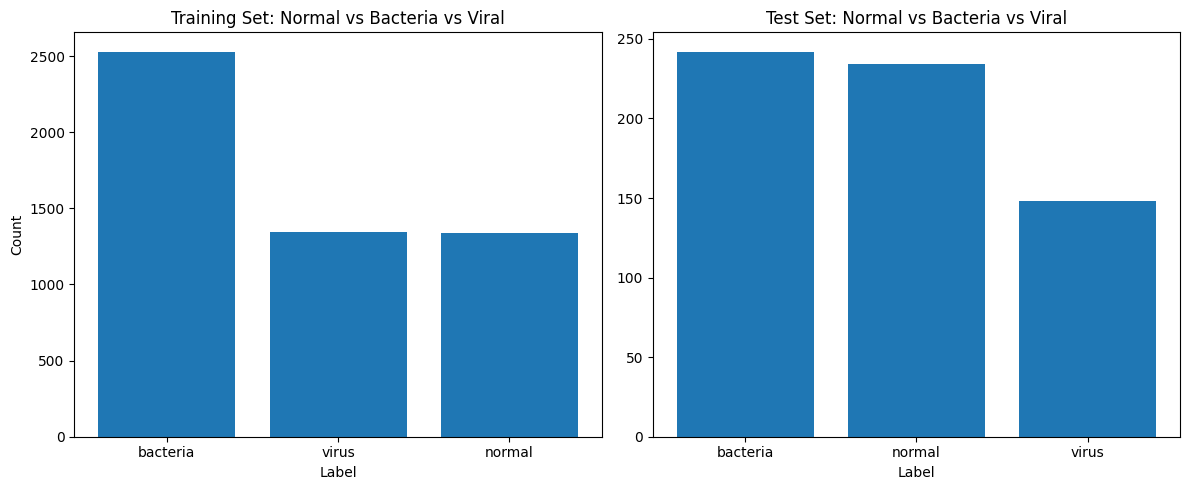

In [11]:
train_counts = train_df['type'].value_counts()
test_counts = test_df['type'].value_counts()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (12,5), sharey=False)

ax1.bar(train_counts.index, train_counts.values)
ax1.set_title('Training Set: Normal vs Bacteria vs Viral')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')

ax2.bar(test_counts.index, test_counts.values)
ax2.set_title('Test Set: Normal vs Bacteria vs Viral')
ax2.set_xlabel('Label')
plt.tight_layout()
plt.show()

### Xray Outliers

The code below calculate's the average pixel intensity of each image and then appends it to a list. With this list, I calculate the total mean pixel intensity and the standard deviation. From there, I loop through every image and any image whose pixel intensity is more than 3 standard deviations away from the mean is excluded and dropped from the dataset.

These images are then plotted below. The underexposed images might be usable, but the overexposed images look a bit too bright to be of value. Since there's only 21 of these images, it is not a big deal to drop them from a total set of ~6000 images.

In [12]:
train_normal_fnames = glob(os.path.join('/home/lukeunix/tf-env/Final - Xray/train/NORMAL','*.jpeg'))
train_pneu_fnames = glob(os.path.join('/home/lukeunix/tf-env/Final - Xray/train/PNEUMONIA','*.jpeg'))
train_img_list = list(train_normal_fnames) + list(train_pneu_fnames)

#calculate pixel intensity of every image and append it to a list
means = []
for img in train_img_list:
    arr = np.array(Image.open(img).convert('RGB'))
    means.append(arr.mean())

std_pop = np.std(means)
avg_pop = np.mean(means)

outlier_idxs = []
for i, j in enumerate(means):
    if j > (3*std_pop + avg_pop) or j < (avg_pop - 3*std_pop):
        outlier_idxs.append(i)
outlier_imgs = []
for i in outlier_idxs:
    if i < len(train_normal_fnames):
        outlier_imgs.append(train_img_list[i])
    else:
        outlier_imgs.append(train_img_list[i])

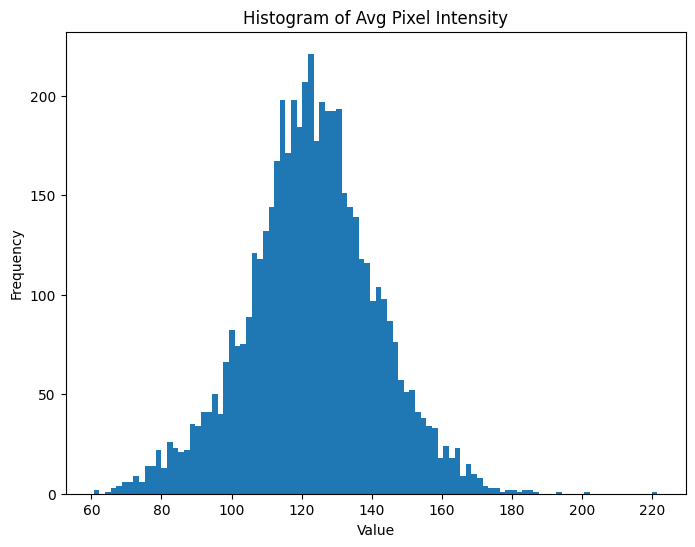

Standard deviation is 18.53
Average is 122.99


In [235]:
plt.figure(figsize=(8, 6))
plt.hist(means, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Avg Pixel Intensity')
plt.show()
print(f'Standard deviation is {std_pop:.02f}')
print(f'Average is {avg_pop:.02f}')

The outliers that are dropped from the training set are shown below.

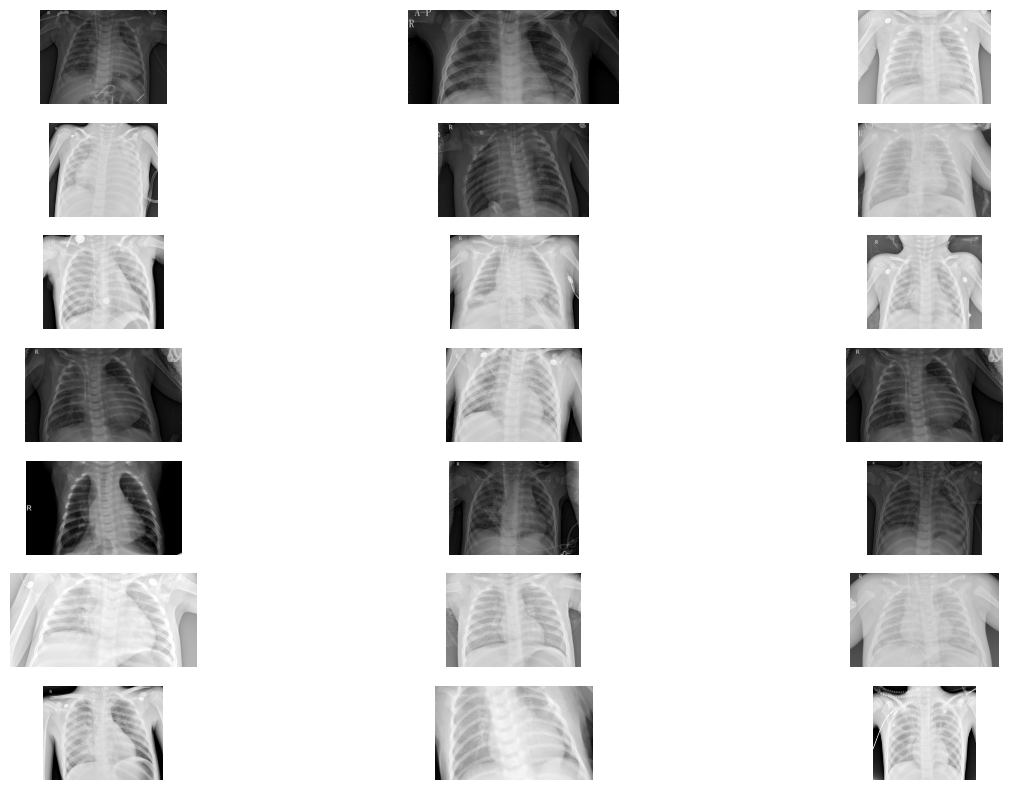

In [276]:
#plot some of them as an example
fig, axes = plt.subplots(7, 3, figsize=(15, 10))
for ax, img_name in zip(axes.flatten(), outlier_imgs):
    img = Image.open(img_name).convert('L')
    ax.imshow(img,cmap='gray')
    ax.axis('off')
plt.show()

In [14]:
outlier_imgs_rem = []
for img in outlier_imgs:
    outlier_imgs_rem.append(os.path.basename(img))
print(f' The number of over or underexposed images in the training set is {len(outlier_imgs_rem)}')

 The number of over or underexposed images in the training set is 21


In [15]:
train_df = train_df[~train_df['filename'].isin(outlier_imgs_rem)]

'-

## Xray Image Preprocessing

Additionally, these files are also pretty large for this project (1000 x 1000 pixels, generally). This would take a very long time to train and would probably fill up my computer's RAM / GPU's VRAM and possibly run into an OOM error (or only allow training models using a batch of 1). I will resize these to 320 x 320 that way the training time is more manageable. 

There are multiple functions that help with pre-processing of the images.

`black_margins` Is a function that determines where there are non-black pixels in the image. With these pixels found, it forms a rectangle that is as small as possible but contains all of the non-black pixels. This rectangle is the crop area, and the image is then cropped. This function helps the model by cropping out any black margins in the image that are not adding value and would be partially retained when resizing from 1000 x 1000 to 320 x 320. Cropping them out first allows the resized image to retain more useful pixels.

`preprocess_xray` is the full preprocessing pipeline used on each image. It reads in the image and converts it into a string of bytes. This is then decoded as a PNG image (channel = 1 means it will be grayscale). The image is of the shape [Height, Width, 1]. Then the `black_margins` function is applied to it. The image is then resized to 320 x 320 pixels. The pixel values are then scaled from 0-255 to 0-1. These value ranges are better for training in models. 

In [16]:
def black_margins(image, tol=0):
    mask = tf.squeeze(image > tol, axis = -1)
    coords = tf.where(mask)

    def no_crop():
        return image
    def do_crop():
        y_min = tf.cast(tf.reduce_min(coords[:,0]), tf.int32)
        x_min = tf.cast(tf.reduce_min(coords[:,1]), tf.int32)
        y_max = tf.cast(tf.reduce_max(coords[:,0]), tf.int32)
        x_max = tf.cast(tf.reduce_max(coords[:,1]), tf.int32)
        return tf.image.crop_to_bounding_box(image, y_min,x_min,y_max - y_min + 1, x_max - x_min + 1)
    return tf.cond(tf.shape(coords)[0] > 0, do_crop, no_crop)

In [17]:
def preprocess_xray(path, label, size=(320,320)):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = black_margins(img, tol=0)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

<hr>

The `tf` dataset object is created below for the training data, binary categorization problem. A batch of 16 was used. For my computer, this was a decent balance of model training speed and avoiding any out of memory errors in the middle of training.

This process also applies a `shuffle` which means the dataset will be shuffled during every epoch of the neural network training. Shuffling the training data obviously helps to produce a robust model since it cannot get stuck in a known pattern of training of looking at the same images in the same order.

The training dataset is split into a training split and a validation split, 80/20. This will be used to track validation loss versus training loss to decide how many epochs to run the model to. When the epoch where the validation loss at a minimum is found, the model will be re-trained on all of the training data and then evaluated against the test data.

In [18]:
file_paths = train_df['full'].tolist()
labels = train_df['label'].tolist()

train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
r_train_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_paths, train_labels))
      .shuffle(buffer_size=len(train_paths))
      .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
      .batch(16)
      .prefetch(AUTOTUNE)
)
r_val_ds = (
    tf.data.Dataset
      .from_tensor_slices((val_paths, val_labels))
      .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
      .batch(16)
      .prefetch(AUTOTUNE)
)
train_ds =  (  
    tf.data.Dataset
      .from_tensor_slices((file_paths, labels))
      .shuffle(buffer_size=len(file_paths))
      .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
      .batch(16)
      .prefetch(AUTOTUNE)
)

I0000 00:00:1747058296.458121    2590 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [19]:
#Create the "test_ds" dataset, since we have not had to do this, yet
test_file_paths = test_df['full'].tolist()
test_labels = test_df['label'].tolist()
test_ds = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))
test_ds = (
    test_ds
    .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
    .batch(16)
    .prefetch(AUTOTUNE)
)

## Model #1

The model used for the binary classification problem is shown below:

`Input` -> `Convolution` -> `MaxPooling` -> `Convolution` -> `MaxPooling` -> `Convolution` -> `MaxPooling` -> `Flatten` -> `Dense` -> `Dropout` -> `Dense`

This is a straightforward CNN model architecture. Three convolution layers progressively increase the feature map depth while reducing the spatial resolution. Each convolution layer is followed by a max pooling layer in order to reduce spatial dimensions, reduce computation, and this makes the network's feature detection robust to small movements. This allows the network to learn high-level and low-level features. CNN's are generally very good at learning and recognizing patterns in images, especially when used for object detection (the object in this case being pneumonia in the lungs). This should be a good model to use for this task.

A 50% dropout / regularization layer is used right before the final Dense layer to reduce the chance of overfitting. 

The model is using the `Adam` optimizer. This combines the advantages of SGD-Momentum and SGD_RMSProp into one algorithm. It does not require *careful* tuning of the global learning rate like SGD would, but the learning rate still requires some hyperparameterization/tuning.

The hyperparameterization of the learning rate is done below by testing values of: 1e-3, 1e-4, 1e-5.

The loss function used is `binary_crossentropy`. This is the correct loss function to use when the final layer is a sigmoid activation and when the problem is a two exclusive classes, such as 0 and 1.

In [64]:
def make_model_1():
    model = Sequential()
    model.add(Input(shape=(320,320,1)))
    model.add(layers.Conv2D(32, (3,3),activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

<hr>

#### Model #1 - LR ~ 1e-3
Initial training will start with the learning rate set at 1e-3 and then gauge whether this is reasonable based off of the validation loss curves versus epoch generated.

In [82]:
model = make_model_1()
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt,metrics=['accuracy'],loss='binary_crossentropy')

In [83]:
history_1 = model.fit(r_train_ds, validation_data = r_val_ds,epochs=10)

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.7299 - loss: 4.0417 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.7407 - loss: 4.1333 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7496 - loss: 3.9912 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.7350 - loss: 4.2248 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.7278 - loss: 4.3397 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.7394 - loss: 4.1548 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.7568 - loss: 3.8779 - val_accuracy: 0.7421 - val_loss: 4.1122
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.7433 - loss: 4.

In [84]:
hist2_acc, hist2_val_acc, hist2_loss, hist2_val_loss = hist_return(history_1)

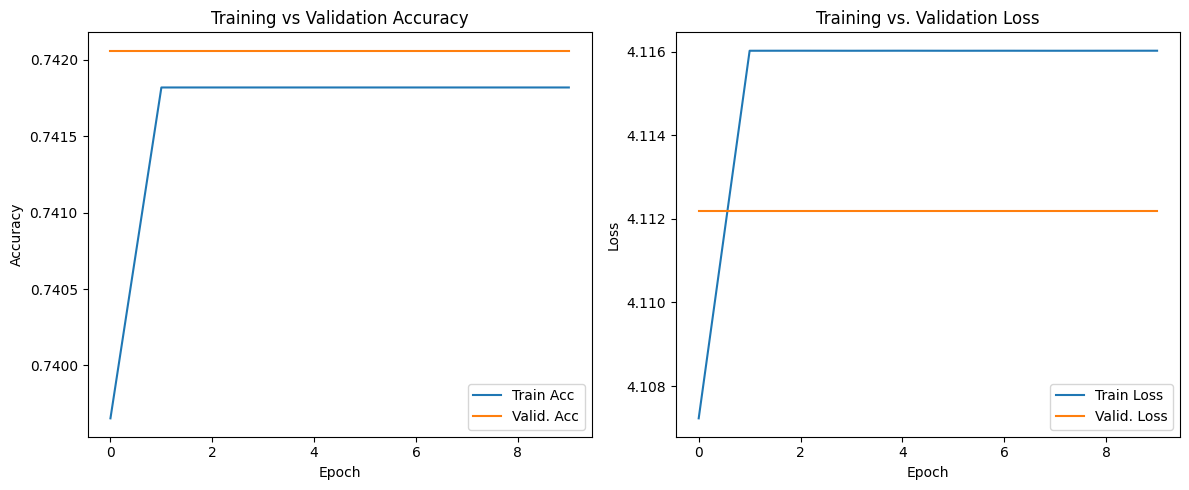

In [85]:
plotter(hist2_acc, hist2_val_acc, hist2_loss, hist2_val_loss)

Plots above show that the learning rate is too high. Learning rate must be < 1e-3. Absolute loss values for the validation loss never decrease and 4.1 is much higher than other plots where it gets into the ~0.10 range.

<hr>

#### Model #1 - LR ~ 1e-4
Next, we will test at 1e-4.

In [74]:
model = make_model_1()
opt = Adam(learning_rate = 1e-4)
model.compile(optimizer=opt,metrics=['accuracy'],loss='binary_crossentropy')

In [75]:
history_1 = model.fit(r_train_ds, validation_data = r_val_ds,epochs=40)

Epoch 1/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - accuracy: 0.7921 - loss: 0.4875 - val_accuracy: 0.9596 - val_loss: 0.1268
Epoch 2/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9471 - loss: 0.1417 - val_accuracy: 0.9702 - val_loss: 0.1128
Epoch 3/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.9588 - loss: 0.1193 - val_accuracy: 0.9654 - val_loss: 0.0926
Epoch 4/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.9515 - loss: 0.1225 - val_accuracy: 0.9644 - val_loss: 0.1226
Epoch 5/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9575 - loss: 0.1177 - val_accuracy: 0.9750 - val_loss: 0.0900
Epoch 6/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9731 - loss: 0.0812 - val_accuracy: 0.9759 - val_loss: 0.1090
Epoch 7/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.9766 - loss: 0.0768 - val_accuracy: 0.9750 - val_loss: 0.0816
Epoch 8/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.9738 - loss: 0.

In [76]:
hist1_acc, hist1_val_acc, hist1_loss, hist1_val_loss = hist_return(history_1)

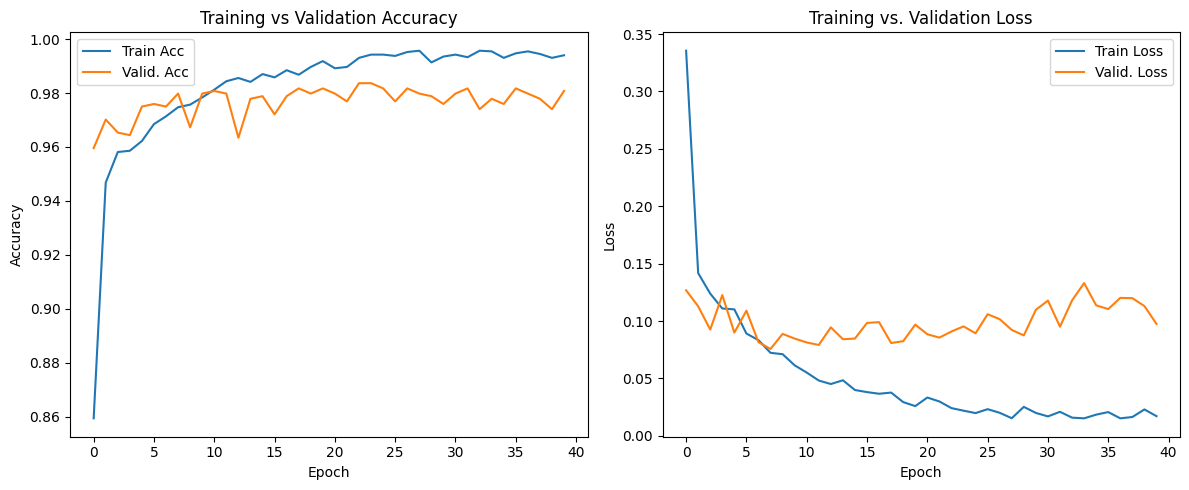

In [77]:
plotter(hist1_acc, hist1_val_acc, hist1_loss, hist1_val_loss)

A learning rate of 1e-4 seems reasonable. Above plots imply I should stop training around 7 - 10 epochs. Validation loss is at a minimum and slowly starts creeping up.

<hr>

#### Model #1 - LR ~ 1e-5
Next, we will test 1e-5 as well to ensure that the prior 1e-4 value is still not too fast. If we can reach a validation loss value that is lower than what was attainable using a learning rate of 1e-4 (~0.075), then we should use 1e-5.

In [65]:
model = make_model_1()
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt,metrics=['accuracy'],loss='binary_crossentropy')

In [66]:
history_1 = model.fit(r_train_ds, validation_data = r_val_ds,epochs=40)

Epoch 1/40
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7353 - loss: 0.5596

2025-05-12 11:16:22.354204: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=0} for conv %cudnn-conv-bw-filter.5 = (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[12,78,78,64]{3,2,1,0} %bitcast.5946, f16[12,76,76,128]{3,2,1,0} %bitcast.5971), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/sequential_1/conv2d_77_1/convolution/Conv2DBackpropFilter" source_file="/home/lukeunix/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-12 11:16:22.670595: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.316539761s
Trying alg

260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.7355 - loss: 0.5592 - val_accuracy: 0.7825 - val_loss: 0.3808
Epoch 2/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.8298 - loss: 0.3695 - val_accuracy: 0.9346 - val_loss: 0.2462
Epoch 3/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9038 - loss: 0.2623 - val_accuracy: 0.9413 - val_loss: 0.1894
Epoch 4/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.9163 - loss: 0.2142 - val_accuracy: 0.9577 - val_loss: 0.1595
Epoch 5/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.9341 - loss: 0.1731 - val_accuracy: 0.9673 - val_loss: 0.1377
Epoch 6/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.9372 - loss: 0.1694 - val_accuracy: 0.9692 - val_loss: 0.1261
Epoch 7/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9442 - loss: 0.1614 - val_accuracy: 0.9654 - val_loss: 0.1123
Epoch 8/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.9470 - loss: 0.1380 - val_accura

In [67]:
hist3_acc, hist3_val_acc, hist3_loss, hist3_val_loss = hist_return(history_1)

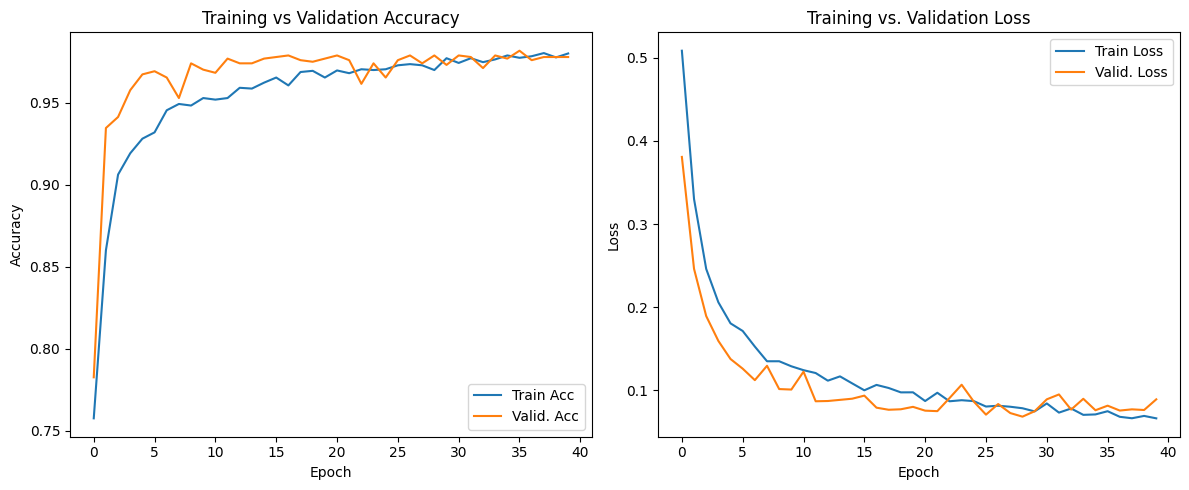

In [68]:
plotter(hist3_acc, hist3_val_acc, hist3_loss, hist3_val_loss)

From the above plots, it is clearly slower than 1e-4. The minimum validation loss is about equal to what was attained when using a learning rate of 1e-4. There is a benefit of using a slower learning rate in the fact that we will more likely be at a minimum validation loss when training to ~25 - 30 epochs whereas with the faster rate, the minimum validation loss is at epoch #8 and you hope that this will carry over when training on the full training dataset, which may not be likely.

For the final learning rate, I will use 1e-5 to be on the safe side and make sure the model is resting at a validation loss minimum. Below, the model is trained to ~26 epochs using the full training data. Predictions and evaluation metrics are also calculated afterward.

In [216]:
model = make_model_1()
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt,metrics=['accuracy'],loss='binary_crossentropy')

In [217]:
history_1 = model.fit(train_ds,epochs=26)

Epoch 1/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.7345 - loss: 0.5654
Epoch 2/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.8453 - loss: 0.3443
Epoch 3/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9198 - loss: 0.2191
Epoch 4/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9316 - loss: 0.1758
Epoch 5/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.9537 - loss: 0.1391
Epoch 6/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9570 - loss: 0.1266
Epoch 7/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9600 - loss: 0.1104
Epoch 8/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9645 - loss: 0.1144
Epoch 9/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.9628 - loss: 0.1063
Epoch 10/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9655 - loss: 0.1104
Epoch 11/26
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9648 - loss: 0.1007
Epoch 12/26
325/325 ━━━━━━━━━━

In [221]:
probs = model.predict(test_ds)
pred = np.argmax(probs, axis=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step


In [43]:
y_true = []
y_score = []
for x_batch, y_batch in test_ds:
    if y_batch.ndim == 2 and y_batch.shape[1] > 1:
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    else:
        y_true.extend(y_batch.numpy().ravel())
    preds = model.predict(x_batch)
    y_score.extend(preds.ravel())
y_true = np.array(y_true)
y_score = np.array(y_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

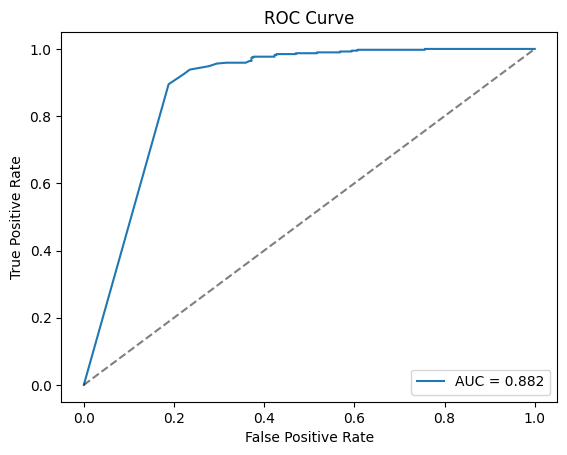

In [44]:
#ROC Curve Generation
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

The ROC Curve is shown above. This is an *OK* classifier.

In [45]:
#compute metrics
accuracy    = accuracy_score(y_true, y_pred)                  
precision   = precision_score(y_true, y_pred)          
f1          = f1_score(y_true, y_pred)           
print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"F1 Score:    {f1:.3f}")

Accuracy:    0.816
Precision:   0.778
F1 Score:    0.870


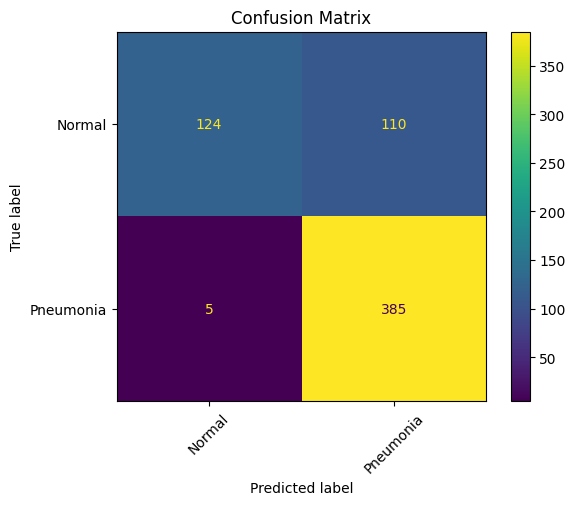

In [46]:
y_pred = (y_score >= 0.5).astype(int)
cm = confusion_matrix(y_true,y_pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

The results are shown above. From the confusion matrix, we can see that that the model is very good at predicting pneumonia when pneumonia is present. Out of 390 true pneumonia Xrays, it predicted 385 of them accurately. Unfortunately, the model does seem to lean towards overpredicting pneumonia since many normal cases also are predicted as pneumonia. From a true normal Xray value of 234, 110 of them are being predicted as pneumonia.

The accuracy is 0.82 and the F1-score is 0.87.

## Model #2 - Improved

A standard "Resnet" style structure is also used. The CNN results earlier were pretty good but I wanted to see if there would be any differences with this type of network. The initial structure is a `convolution layer` -> `activation` -> `max pool`. This reduces the spatial dimensions while increasing the channels. After this is done, the "Resnet" style of the architecture is used. There are three Resnet stages where each stage uses two `resblocks`. Each `resblock` is a `Conv2D` -> `Activation` -> `Conv2D` -> `Activation` pattern.

This network is no longer built using `Sequential` since Sequential does not support the skip connection functionality that a Resnet / resblock requires.

The benefit of a Resnet style structure versus the CNN is that Resnets add a "skip" connection that let the network learn residuals on top of the input mapping. In a normal CNN, as you add more layers, the training error eventually increases because gradients vanish or explode. In a Resnet, each block learns the input and the residual. If a layer isn't helpful to the overall problem, it can move the residual towards zero and just let the skip connection carry the input along. This gives gradients a path backward through many layers and allows you to train deep networks. In essence, Resnets are a *better* CNN because the skip connections allows you to build a CNN as deep as you want it to be. Since a CNN was a good approach for this task originally, a Resnet should be a good idea as well.

This model trains very fast and I had to reduce the learning rate to 2e-6. Finding a "good" value for the learning rate for this model is not explicitly shown in this workbook since the work would be a duplicate of what I did for the CNN case.



In [33]:
def resblock(x, filters, strides = 1):
    skip = x
    x = Conv2D(filters, (3,3), strides=strides, padding='same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    if strides != 1 or skip.shape[-1] != filters:
        skip = Conv2D(filters, (1,1), strides = strides, use_bias = False)(skip)
        skip = BatchNormalization()(skip)
    x = Add()([x, skip])
    x = Activation('relu')(x)
    return x

In [43]:
def make_model_2(input_shape = (320, 320, 1), dropout = 0.5):
    inpu = Input(input_shape)
    x = Conv2D(64, (7,7), strides = 2, padding = 'same', use_bias = False)(inpu)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides = 2, padding = 'same')(x)
    x = resblock(x, 64, strides = 1)
    x = resblock(x, 64, strides = 1)
    x = resblock(x, 128, strides = 2)
    x = resblock(x, 128, strides = 1)
    x = resblock(x, 256, strides = 2)
    x = resblock(x, 256, strides = 1)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation = 'sigmoid')(x)
    return Model(inpu, output)

In [44]:
model = make_model_2()
opt = Adam(learning_rate = 2e-6)
model.compile(optimizer=opt,metrics=['accuracy'],loss='binary_crossentropy')

In [45]:
history_1 = model.fit(r_train_ds, validation_data = r_val_ds,epochs=60)

Epoch 1/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.6953 - loss: 0.5843 - val_accuracy: 0.7421 - val_loss: 0.9199
Epoch 2/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8464 - loss: 0.3546 - val_accuracy: 0.7421 - val_loss: 1.0897
Epoch 3/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8727 - loss: 0.3038 - val_accuracy: 0.8200 - val_loss: 0.3137
Epoch 4/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.8923 - loss: 0.2690 - val_accuracy: 0.8826 - val_loss: 0.2647
Epoch 5/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.8987 - loss: 0.2598 - val_accuracy: 0.9047 - val_loss: 0.2259
Epoch 6/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.9080 - loss: 0.2338 - val_accuracy: 0.9249 - val_loss: 0.1997
Epoch 7/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9172 - loss: 0.2207 - val_accuracy: 0.9317 - val_loss: 0.1838
Epoch 8/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.9210 - loss: 0.2111 -

In [46]:
hist5_acc, hist5_val_acc, hist5_loss, hist5_val_loss = hist_return(history_1)

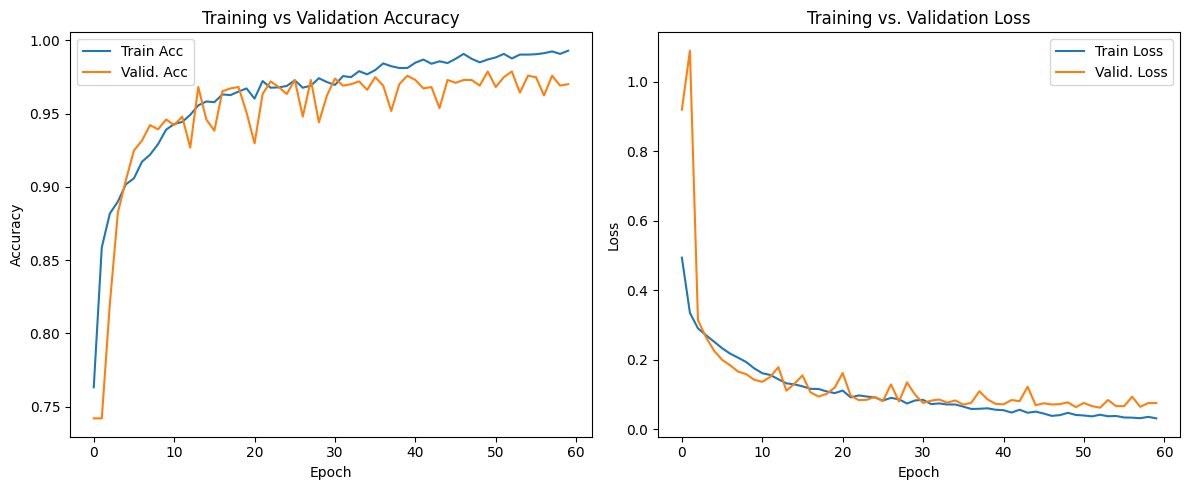

In [47]:
plotter(hist5_acc, hist5_val_acc, hist5_loss, hist5_val_loss)

In [50]:
loss, acc = model.evaluate(test_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4982 - loss: 2.0576


In [51]:
print(acc)

0.7387820482254028


Tried learning rates above 2e-6 but the validation losses start becoming unstable. The validation loss appears stable and at a minimum near ~epoch 50.

The model will be trained against the full training dataset up to 50 epochs and then it will be evaluated against the test dataset.

In [52]:
model = make_model_2()
opt = Adam(learning_rate = 2e-6)
model.compile(optimizer=opt,metrics=['accuracy'],loss='binary_crossentropy')

In [53]:
history_1 = model.fit(train_ds,epochs=50)

Epoch 1/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.6749 - loss: 0.6015
Epoch 2/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.8460 - loss: 0.3417
Epoch 3/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.8832 - loss: 0.2889
Epoch 4/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.8987 - loss: 0.2580
Epoch 5/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.9133 - loss: 0.2251
Epoch 6/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.9225 - loss: 0.2018
Epoch 7/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.9298 - loss: 0.1885
Epoch 8/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9358 - loss: 0.1872
Epoch 9/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.9491 - loss: 0.1485
Epoch 10/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9520 - loss: 0.1439
Epoch 11/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9514 - loss: 0.1405
Epoch 12/50
325/325 ━━━━━━━━━

In [54]:
loss, acc = model.evaluate(test_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8223 - loss: 0.5374


In [55]:
print(acc)

0.879807710647583


In [56]:
y_true = []
y_score = []
for x_batch, y_batch in test_ds:
    if y_batch.ndim == 2 and y_batch.shape[1] > 1:
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    else:
        y_true.extend(y_batch.numpy().ravel())
    preds = model.predict(x_batch)
    y_score.extend(preds.ravel())
y_true = np.array(y_true)
y_score = np.array(y_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━

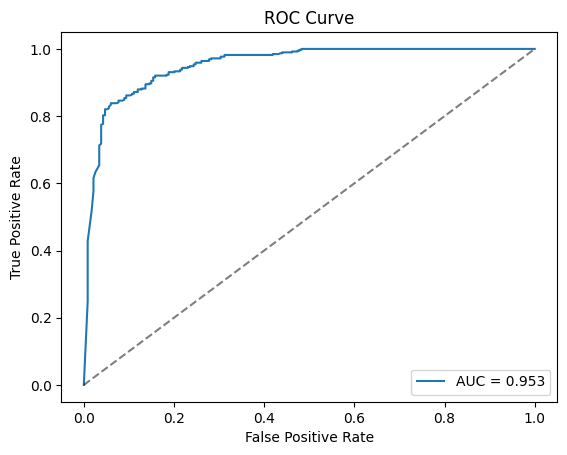

In [57]:
#ROC Curve Generation
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

Compared to the prior CNN model, this ROC curve is much better with an AUC of 0.95.

In [59]:
#compute metrics
y_pred = (y_score >= 0.5).astype(int)
accuracy    = accuracy_score(y_true, y_pred)                  
precision   = precision_score(y_true, y_pred)          
f1          = f1_score(y_true, y_pred)           
print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"F1 Score:    {f1:.3f}")

Accuracy:    0.880
Precision:   0.874
F1 Score:    0.908


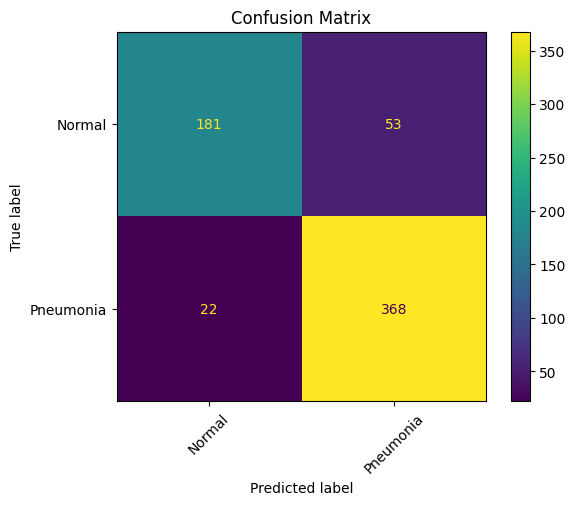

In [60]:
cm = confusion_matrix(y_true,y_pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

Comparing the Resnet style model to the CNN style model, the Resnet is clearly superior for this classification problem. From the confusion matrix, we can see that the model predicts true pneumonia cases very strongly still (368 / 390 true cases correctly predicted), but it also has the benefit of predicting the true normal cases much more accurately. The false positives in the CNN model (110) are about double the value of the Resnet model (53).

The accuracy and F1-scores are also better: 0.88 accuracy and 0.91 F1-score.

## 3-Case Model: Normal, Viral, or Bacterial Cases
The model used for the 3-case Xray classification is the same as the CNN model before except the final Dense layer is no longer using a sigmoid activation but instead a softmax activation function. This calculates a probability distribution of each sample belonging to each case (normal, bacteria, viral) where the majority vote is the label.

Since this is no longer a binary problem, the loss function was changed to `categorical_crossentropy`. This is the correct loss function to use when the activation is Softmax and when the problem is a multi-class problem where exactly one class is correct, such as in this problem where the solutions are 0, 1, or 2.

In [80]:
file_paths = train_df['full'].tolist()
string_labels = train_df['type'].tolist()
label_dict = {"normal":0,"virus":1,"bacteria":2}
int_labels = []
for s in string_labels:
    int_labels.append(label_dict[s])
int_labels = np.array(int_labels)
encoded_labels = to_categorical(int_labels,num_classes = 3)
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=int_labels
)
r_train_ds3 = (
    tf.data.Dataset
      .from_tensor_slices((train_paths, train_labels))
      .shuffle(buffer_size=len(train_paths))
      .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
      .batch(16)
      .prefetch(AUTOTUNE)
)
r_val_ds3 = (
    tf.data.Dataset
      .from_tensor_slices((val_paths, val_labels))
      .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
      .batch(16)
      .prefetch(AUTOTUNE)
)
train_ds3 =  (  
    tf.data.Dataset
      .from_tensor_slices((file_paths, encoded_labels))
      .shuffle(buffer_size=len(file_paths))
      .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
      .batch(16)
      .prefetch(AUTOTUNE)
)

In [ ]:
#Create the "test_ds3" dataset, since we have not had to do this, yet
test_file_paths = test_df['full'].tolist()
test_string_labels = test_df['type'].tolist()
label_dict = {"normal":0,"virus":1,"bacteria":2}
test_int_labels = []
for s in test_string_labels:
    test_int_labels.append(label_dict[s])
test_int_labels = np.array(test_int_labels)
test_encoded_labels = to_categorical(test_int_labels,num_classes = 3)

test_ds3 = tf.data.Dataset.from_tensor_slices((test_file_paths, test_encoded_labels))
test_ds3 = (
    test_ds3
    .map(preprocess_xray, num_parallel_calls=AUTOTUNE)
    .batch(16)
    .prefetch(AUTOTUNE)
)

In [81]:
def make_model_3split():
    model = Sequential()
    model.add(Input(shape=(320,320,1)))
    model.add(layers.Conv2D(32, (3,3),activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    return model

In [84]:
model = make_model_3split()
opt = Adam(learning_rate = 5e-5)
model.compile(optimizer=opt,metrics=['accuracy'],loss='categorical_crossentropy')

In [85]:
history_1 = model.fit(r_train_ds3, validation_data = r_val_ds3,epochs=60)

Epoch 1/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.5096 - loss: 0.9996 - val_accuracy: 0.7680 - val_loss: 0.6125
Epoch 2/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7501 - loss: 0.6201 - val_accuracy: 0.7902 - val_loss: 0.5133
Epoch 3/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.7768 - loss: 0.5416 - val_accuracy: 0.7969 - val_loss: 0.4803
Epoch 4/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7863 - loss: 0.5059 - val_accuracy: 0.7931 - val_loss: 0.4688
Epoch 5/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.7991 - loss: 0.4886 - val_accuracy: 0.7911 - val_loss: 0.4699
Epoch 6/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7860 - loss: 0.4714 - val_accuracy: 0.8017 - val_loss: 0.4681
Epoch 7/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.7987 - loss: 0.4551 - val_accuracy: 0.8085 - val_loss: 0.4554
Epoch 8/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.8073 - loss: 0.4274 

In [86]:
hist6_acc, hist6_val_acc, hist6_loss, hist6_val_loss = hist_return(history_1)

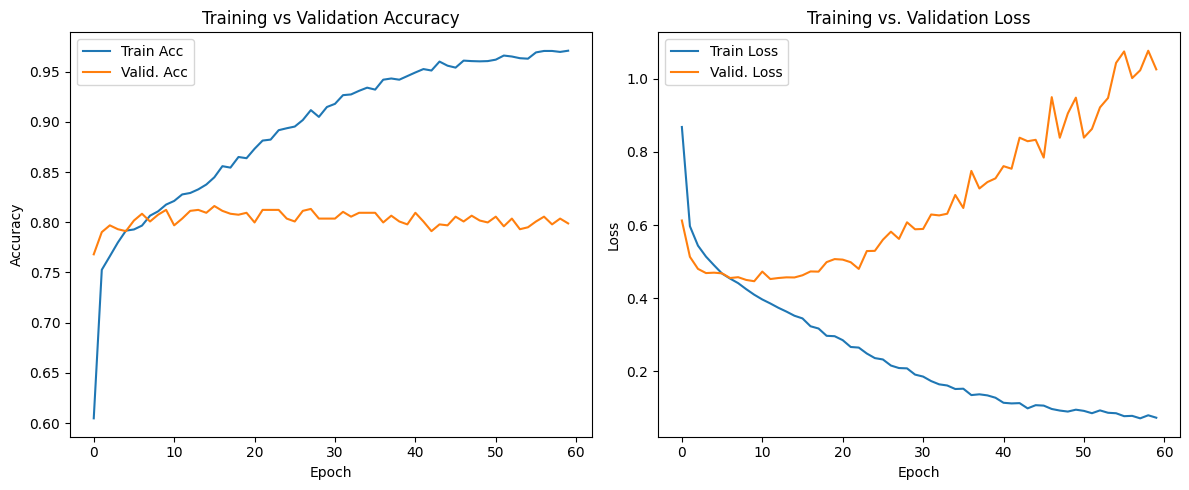

In [87]:
plotter(hist6_acc, hist6_val_acc, hist6_loss, hist6_val_loss)

In [89]:
loss, acc = model.evaluate(test_ds3)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5872 - loss: 4.3999


In [90]:
print(acc)

0.6875


<hr>

The validation loss takes off pretty quickly after ~10 epochs. I will train a model up to 10 epochs on the entire training dataset and then predict on the test set and calculate the metrics below.

In [92]:
model = make_model_3split()
opt = Adam(learning_rate = 5e-5)
model.compile(optimizer=opt,metrics=['accuracy'],loss='categorical_crossentropy')

In [93]:
history_1 = model.fit(train_ds3,epochs=10)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.5551 - loss: 0.9438
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.7634 - loss: 0.5706
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.7742 - loss: 0.5212
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.7751 - loss: 0.5032
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.7845 - loss: 0.4778
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.7958 - loss: 0.4656
Epoch 7/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.7979 - loss: 0.4518
Epoch 8/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.8006 - loss: 0.4481
Epoch 9/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.8110 - loss: 0.4221
Epoch 10/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.8216 - loss: 0.4107


In [104]:
y_true = []
y_score = []
for x_batch, y_batch in test_ds3:
    if y_batch.ndim == 2 and y_batch.shape[1] > 1:
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    else:
        y_true.extend(y_batch.numpy().ravel())
    preds = model.predict(x_batch)
    y_score.append(preds)
y_true = np.array(y_true)
y_score = np.vstack(y_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━

In [107]:
#compute metrics
y_pred = np.argmax(y_score,axis=1)
accuracy    = accuracy_score(y_true, y_pred)                  
precision   = precision_score(y_true, y_pred, average='weighted')          
f1          = f1_score(y_true, y_pred, average='weighted')           
print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"F1 Score:    {f1:.3f}")

Accuracy:    0.696
Precision:   0.772
F1 Score:    0.681


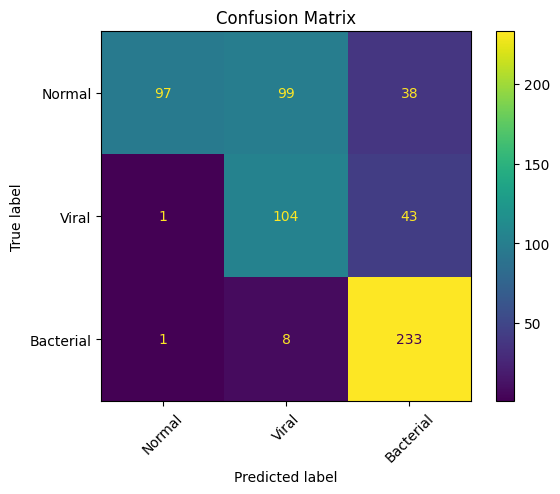

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true,y_pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Viral','Bacterial'])
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

Since this is a more difficult problem, it is not surprising that the confusion matrix and accuracy metrics are not as good. The accuracy is ~0.70 and the F1-score is 0.68.

Although the evaluation metrics appear poor, the model is performing better than what the metrics would have you believe. Looking at the confusion matrix, it accurately predicts bacterial pneumonia when present. Out of 242 bacterial pneumonia cases: 1 is labelled as normal, 8 is labelled as viral, and 233 are labelled as bacterial. This is pretty good, there are not many bacterial pneumonia cases being mislabelled as Normal!

Looking at the viral case, out of 148 viral pneumonia cases: 1 is labelled as viral, 104 are labelled as viral, and 43 are labelled as bacterial. Again, at least the model is not mislabelling pneumonia cases as normal. It is unfortunate that it is having difficulty making the distinction between viral and bacterial for the true viral cases but this is a better problem to have than mislabelling xrays with pneumonia present as normal.

It appears that the evaluation metrics are being reduced significantly since most of the error is on the model accurately labelling normal cases. Out of 234 normal Xrays, 97 are labelled as normal, 99 are labelled as viral pneumonia, and 38 are labelled as bacterial pneumonia. It looks bad but I do consider this some form of success. I would rather have a model strongly predict pneumonia when pneumonia is present and overly predict it on normal Xrays than to miss pneumonia on Xrays which have pneumonia.

### 3-Case Model: Resnet Example
Similar to what I did for the binary classification problem earlier, I will copy the Resnet structure I used and see how well it performs on the 3-case pneumonia problem (normal, viral, bacterial). Again, the only change needed was to change the final Dense layer to have 3 output neurons and to change the activation function to softmax instead of sigmoid.

This model trains very fast and I had to reduce the learning rate to 2e-6. Finding a "good" value for the learning rate for this model is not explicitly shown in this workbook since the work would be a duplicate of what I did for the CNN case.

In [140]:
def make_model_3split_Resnet(input_shape = (320, 320, 1), dropout = 0.5):
    inpu = Input(input_shape)
    x = Conv2D(64, (7,7), strides = 2, padding = 'same', use_bias = False)(inpu)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides = 2, padding = 'same')(x)
    x = resblock(x, 64, strides = 1)
    x = resblock(x, 64, strides = 1)
    x = resblock(x, 128, strides = 2)
    x = resblock(x, 128, strides = 1)
    x = resblock(x, 256, strides = 2)
    x = resblock(x, 256, strides = 1)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation = 'softmax')(x)
    return Model(inpu, output)

In [171]:
model = make_model_3split_Resnet()
opt = Adam(learning_rate = 2e-6)
model.compile(optimizer=opt,metrics=['accuracy'],loss='categorical_crossentropy')

In [172]:
history_1 = model.fit(r_train_ds3, validation_data = r_val_ds3,epochs=45)

Epoch 1/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.4089 - loss: 1.3227 - val_accuracy: 0.4841 - val_loss: 1.2911
Epoch 2/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.5296 - loss: 1.0931 - val_accuracy: 0.4841 - val_loss: 1.3740
Epoch 3/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.5875 - loss: 0.9391 - val_accuracy: 0.6285 - val_loss: 0.7728
Epoch 4/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.6134 - loss: 0.8852 - val_accuracy: 0.7209 - val_loss: 0.6574
Epoch 5/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.6367 - loss: 0.8418 - val_accuracy: 0.7334 - val_loss: 0.6325
Epoch 6/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.6755 - loss: 0.7754 - val_accuracy: 0.7459 - val_loss: 0.6218
Epoch 7/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.6637 - loss: 0.7910 - val_accuracy: 0.7517 - val_loss: 0.6143
Epoch 8/45
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.6721 - loss: 0.7649 -

In [177]:
hist7_acc, hist7_val_acc, hist7_loss, hist7_val_loss = hist_return(history_1)

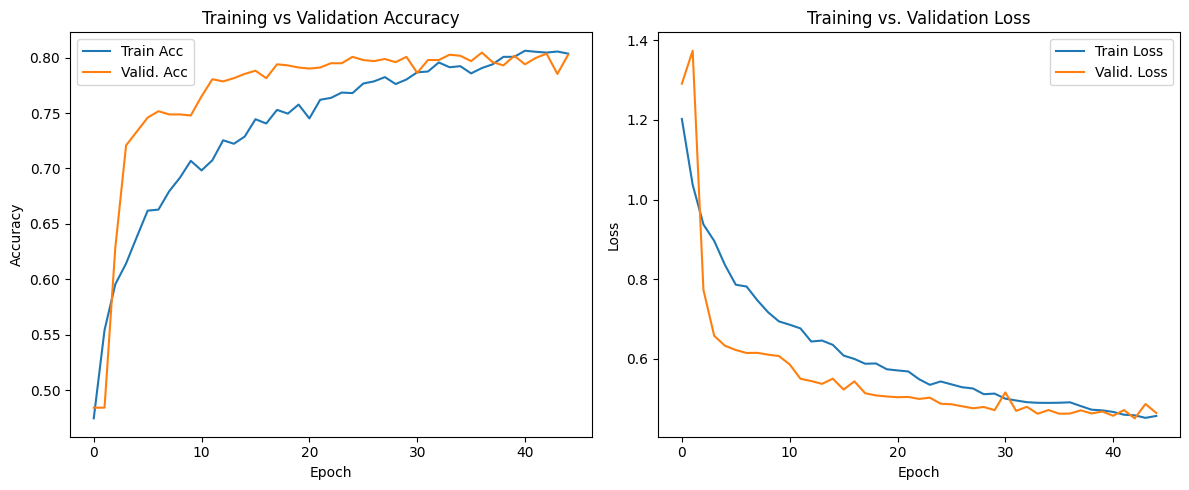

In [178]:
plotter(hist7_acc, hist7_val_acc, hist7_loss, hist7_val_loss)

<hr>

Epoch 40 appears to be around the minimum validation loss. Will train a model on the full training data up to epoch 40 and predict results.

In [186]:
model = make_model_3split_Resnet()
opt = Adam(learning_rate = 2e-6)
model.compile(optimizer=opt,metrics=['accuracy'],loss='categorical_crossentropy')

In [187]:
history_1 = model.fit(train_ds3,epochs=40)

Epoch 1/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.4601 - loss: 1.1780
Epoch 2/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.5603 - loss: 0.9240
Epoch 3/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.5964 - loss: 0.8651
Epoch 4/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.6271 - loss: 0.8147
Epoch 5/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.6531 - loss: 0.7684
Epoch 6/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.6774 - loss: 0.7450
Epoch 7/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.6971 - loss: 0.7025
Epoch 8/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.7092 - loss: 0.6936
Epoch 9/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.7184 - loss: 0.6682
Epoch 10/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.7182 - loss: 0.6534
Epoch 11/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.7364 - loss: 0.6235
Epoch 12/40
325/325 ━━━━━━━━━

In [188]:
loss, acc = model.evaluate(test_ds3)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7298 - loss: 0.7566


In [189]:
print(acc)

0.7932692170143127


In [190]:
y_true = []
y_score = []
for x_batch, y_batch in test_ds3:
    if y_batch.ndim == 2 and y_batch.shape[1] > 1:
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    else:
        y_true.extend(y_batch.numpy().ravel())
    preds = model.predict(x_batch)
    y_score.append(preds)
y_true = np.array(y_true)
y_score = np.vstack(y_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

In [193]:
#compute metrics
y_pred = np.argmax(y_score,axis=1)
accuracy    = accuracy_score(y_true, y_pred)                  
precision   = precision_score(y_true, y_pred, average='weighted')          
f1          = f1_score(y_true, y_pred, average='weighted')           
print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"F1 Score:    {f1:.3f}")

Accuracy:    0.793
Precision:   0.815
F1 Score:    0.790


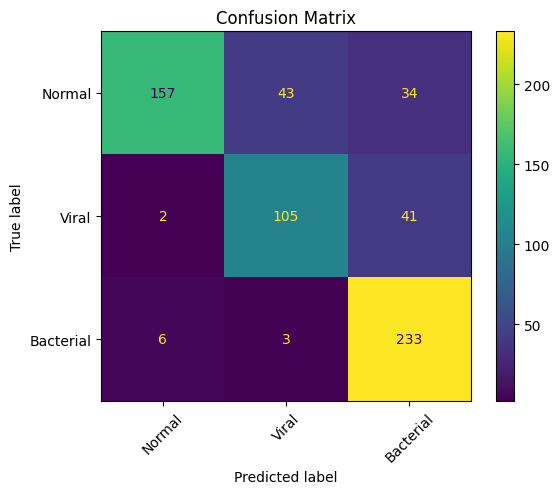

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true,y_pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Viral','Bacterial'])
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

The above results shows a clear improvement when going from the CNN structure to a Resnet style model. The accuracy increased from 0.70 to 0.79 and the F1-score increased from 0.68 to 0.79.

Additionally, the confusion matrix improved as well. The bacterial and viral true labels are mostly the same as before, except in this model it is much better at labelling the true normals. The true normals before were 97 and have been increased to 157.

## Summarized Results

|Model|Accuracy|F1-Score|Learn Rate|Loss Function|Optimizer|
|-|-|-|-|-|-|
|CNN Bin Classification|0.82|0.87|1e-5|binary_crossentropy|Adam|
|Resnet Bin Classification|0.88|0.91|2e-6|binary_crossentropy|Adam|
|CNN 3-Case Categorization|0.70|0.68|5e-5|categorical_crossentropy|Adam|
|Resnet 3-Case Categorization|0.79|0.79|2e-6|categorical_crossentropy|Adam|

The Resnet style models are superior quantitatively and qualitatively to the CNN style models for the binary classification and the 3-Case categorization problems.

The learning rates between the Resnet and the CNN models are ~10x different than each other. The learning rates were first tuned on the basic binary classification problem using the CNN models testing values (1e-3, 1e-4, 1e-5). 1e-3 was too unstable and the validation loss never was reduced to a minimum. 1e-4 worked well and was fast. 1e-5 was slower than 1e-4 but allowed more leniency on training to the optimal epoch to arrive at the minimum validation loss, so that is what was chosen for the CNN Bin Classification modelling. The Resnet models were immediately unstable using 1e-5, it was too fast. Numbers in the e-6 range still had moments of instability where the validation loss spiked but it was on the whole reasonable.

Interestingly enough, if a learning rate was too high for the CNN models, it was immediately apparent early on in the training. This was not the case with the Resnet models. The Resnet models could look stable for ~5 epochs, and then have a severe spike, and then later become temporarily stable again.

An attempt was also made at adjusting the train/validation split (80/20 -> 90/10) in order to 'give' the training set more data and with that, more "normal" cases in its training. This unfortunately did not make much of a difference in increasing the normal sensitivity value.

The plots of the sensitivity is also shown for each of the different models. Sensitivity is the probability of a positive test result, conditioned on the individual by being positive. I believe for this modelling problem this is an important metric to consider since it explains the predictive power of the model best. When an Xray contains pneumonia, how often do we really catch it?

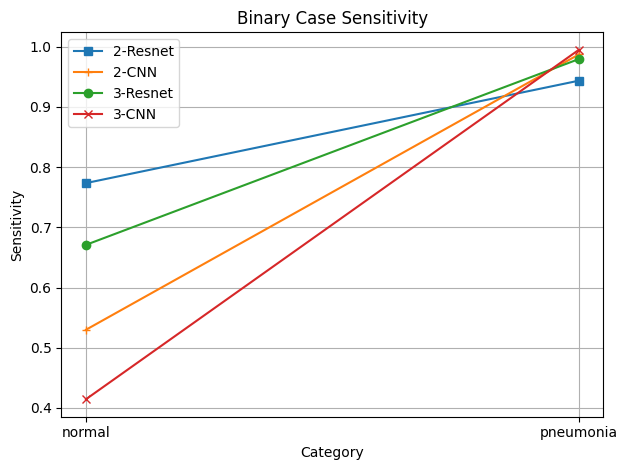

In [215]:
CNNBin = [(124/(124+110)),(385/(385+5))]
ResBin = [(181/(181+53)),(368/(368+22))]
CNN3Sens = [(97/(97+137)),(388/(388+2))]
Res3Sens = [(157/(157+77)),(382/(382+8))]
labels = ['normal','pneumonia']
plt.figure()
plt.plot(labels, ResBin, marker='s',label='2-Resnet')
plt.plot(labels, CNNBin, marker='+',label='2-CNN')
plt.plot(labels, Res3Sens, marker='o',label='3-Resnet')
plt.plot(labels, CNN3Sens, marker='x',label='3-CNN')
plt.xlabel('Category')
plt.ylabel('Sensitivity')
plt.title('Binary Case Sensitivity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In the above plot, I also included the 3-Case results. For these, to accurately compare it with the binary classification problem, I combined the viral and pneumonia results into one category, 'pneumonia'.

With the above plots it's a clear pattern that the CNN type model is worse at predicting true Normal Xrays. Each time the model is changed to a Resnet, the Normal sensitivity increases by ~0.25 to 0.30 with a small effect on decreasing the pneumonia's sensitivity.

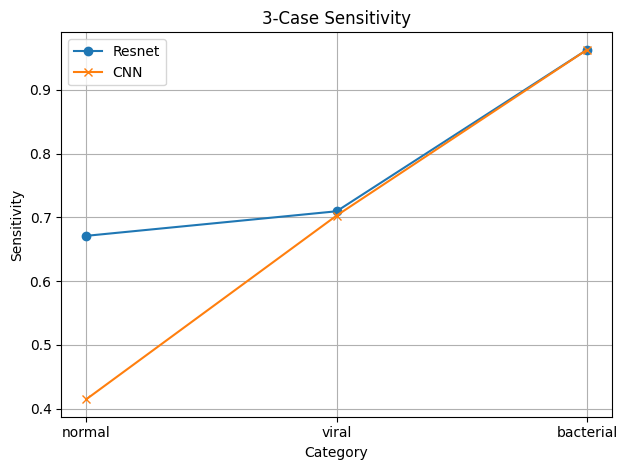

In [213]:
CNN3Sens = [(97/(97+99+38)),(104/(104+43+1)),(233/(233+8+1))]
Res3Sens = [(157/(157+43+34)),(105/(105+41+2)),(233/(233+3+6))]
labels = ['normal','viral','bacterial']
plt.figure()
plt.plot(labels, Res3Sens, marker='o',label='Resnet')
plt.plot(labels, CNN3Sens, marker='x',label='CNN')
plt.xlabel('Category')
plt.ylabel('Sensitivity')
plt.title('3-Case Sensitivity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The above plot clearly shows the difference from the CNN to the Resnet model : The normal case sensitivity increases from ~0.40 to ~0.68. When an Xray is **true** normal, the model has a 68% chance of accurately predicting this. Similarly, when an Xray contains a **true** bacterial pneumonia infection, it has a 97% chance of properly labelling it.



## Discussions and Conclusions

As discussed in each of the respective modelling sections, the CNN and Resnet models are both good at this classification problem. The pneumonia positive/negative binary problem is obviously easier but the models were very good at predicting the 3-case classification as well (normal, bacterial, viral).

Although the accuracies for some of the models appear pretty "poor", this does not tell the whole story of the model's predictive power. For each of the models, they are all very strong at predicting pneumonia when pneumonia is present on the Xray. Almost all of the error for the models is due to predicting that pneumonia is present on **normal** Xrays (which is a less serious problem than predicting that a pneumonia containing Xray is normal, from a practical standpoint). Even the 3-case problem is very good at predicting the presence of pneumonia AND it is powerful at detecting which type of pneumonia is present on the Xray (viral/bacterial). As with the binary classification problem, the accuracy is low since the model will predict that normal Xrays have pneumonia more often than it should.

From these results, I would trust these models when it says that an Xray is **normal**. Any results that predicts that an Xray has pneumonia should require a second look to confirm the results and make sure it is not a false positive. The Resnet models for both cases are both superior to the CNN models so these would be the models I would use in a real application setting. Training this Resnet model was just as fast as the CNN model at ~30s / epoch.

### Limitations
The major limitation is that the dataset is not particularly large. The training set was only **1341** normal Xrays + **3875** pneumonia Xrays. The small amount of normal Xrays directly contributes to the model's poor ability to predict the true normal cases. I would assume that the model's predictive power with respect to accurately labelling normal Xrays would be much better if the training set had more normal representative samples. This problem is compounded since I am performing a typical 80/20 training/test split when deciding where to stop training epochs. I suppose most people do not receive an Xray when they're feeling just fine, but more images would help.

### Future Improvements
The first improvement is to gather more normal Xray images. Maybe incorporate images from another dataset if they are of a similar quality.

The second improvement is to make use of *lung-field segmentation*. There are some Xray datasets that exist where radiologists have explicitly drawn a mask / outlined the lungs. With this sort of dataset, you could create a model specifically to be able to identify and outline the regions of the Xray that are the lungs and then to ignore or cropout anything else that is not a lung. With this, the actual downstream model that is trained and is focused on this "mask" can just focus on the anatomy that matters when it is detecting pneumonia. This helps to focus the model and then it will not be trained on random artifacts or oddness across different Xrays that are not specific to the lungs. This also reduces the chance that the model could learn from markers that it should not: i.e., maybe some hospitals put a small dot in a specific part of the Xray which noted an irregularity (which the model picked up on and was learning from), or maybe some Xray machines have their own irregularities that affect the appearance of the Xray.

### References

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), *"Labeled Optical Coherence Tomography (OCT) and Chest X-ray Images for Classification"*, Mendelay Data, v2